In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.18.0


In [2]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, \
  Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2025-03-31 18:33:44--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  57.0MB/s    in 3.3s    

2025-03-31 18:33:48 (57.0 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [5]:
!ls

ml-20m	ml-20m.zip  sample_data


In [6]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [8]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [9]:
#Get userId ,movieId and ratings into seperate Arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values

In [10]:
# Getting number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))
print(N)
print(M)

138493
26744


In [11]:
#Setting Embedding Dimension
K = 10

In [12]:
# Neural Network

#Inputs
u = Input(shape=(1,))
m = Input(shape=(1,))

#Embeddings
# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 1, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)

# Flatten both embeddings
u_emb = Flatten()(u_emb) # now it's (num_samples, K)
m_emb = Flatten()(m_emb) # now it's (num_samples, K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
x = Dense(400, activation='relu')(x)
x = Dense(1)(x)

In [13]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(learning_rate=0.08, momentum=0.9),
)

In [14]:
# split the data
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# center the ratings
avg_rating = train_ratings.mean()
train_ratings = train_ratings - avg_rating
test_ratings = test_ratings - avg_rating

In [15]:
r = model.fit(
  x=[train_user, train_movie],
  y=train_ratings,
  epochs=10,
  batch_size=1024,
  validation_data=([test_user, test_movie], test_ratings),
)

Epoch 1/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 66s 4ms/step - loss: 0.8204 - val_loss: 0.7200
Epoch 2/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - loss: 0.7030 - val_loss: 0.6963
Epoch 3/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - loss: 0.6795 - val_loss: 0.6824
Epoch 4/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - loss: 0.6621 - val_loss: 0.6775
Epoch 5/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - loss: 0.6499 - val_loss: 0.6698
Epoch 6/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - loss: 0.6389 - val_loss: 0.6600
Epoch 7/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 85s 4ms/step - loss: 0.6220 - val_loss: 0.6487
Epoch 8/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - loss: 0.6057 - val_loss: 0.6435
Epoch 9/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - loss: 0.5950 - val_loss: 0.6397
Epoch 10/10
15626/15626 ━━━━━━━━━━━━━━━━━━━━ 83s 4ms/step - loss: 0.5857 - val_loss: 0.6353


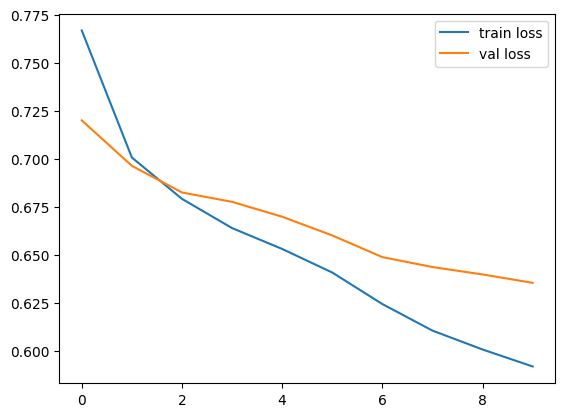

In [16]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.legend()
plt.show()

In [17]:
np.sqrt(0.6259)

np.float64(0.7911384202527394)